Letter Analysis

In [ ]:
import os
import shutil
import paramiko
import pandas as pd
from scp import SCPClient
from posixpath import join
import matplotlib.pyplot as plt

run_id = 3
jar_name = 'letter-frequency-1.0-SNAPSHOT.jar'

First analyze the letter frequencies in books across the eras. As performance is not relevant now, the job will be executed with 1 reducer, using combiner.
We hypotize that the input files are already in the input folder in hdfs, in /user/hadoop/letter_analysis/input/.

In [ ]:
# connect with ssh
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')
root_dir = '/user/hadoop/historical_analysis'

# run the job for each file
for txt_file in os.listdir('../resources/historical_analysis/input'):
    print(f'Processing {txt_file}')
    input_dir = join(root_dir, 'input', txt_file)
    output_dir = join(root_dir, f'output_{run_id}', txt_file.split('.')[0])
    stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp '
                                             f'{input_dir} {output_dir}/count {output_dir}/freq 1 inmappercombiner')
    print(stderr.read().decode('utf-8'))
    print(stdout.read().decode('utf-8'))

# copy the output to local
stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal /user/hadoop/historical_analysis/output_{run_id} .')
print(stderr.read().decode('utf-8'))

if not os.path.exists(f'../resources/historical_analysis/output_{run_id}'):
    os.mkdir(f'../resources/historical_analysis/output_{run_id}')
    
scp = SCPClient(ssh.get_transport())
scp.get(f'output_{run_id}', '../resources/historical_analysis/', recursive=True)

# remove the output
ssh.exec_command(f'rm -r output_{run_id}')
scp.close()
ssh.close()

After that we can analyze the output files.

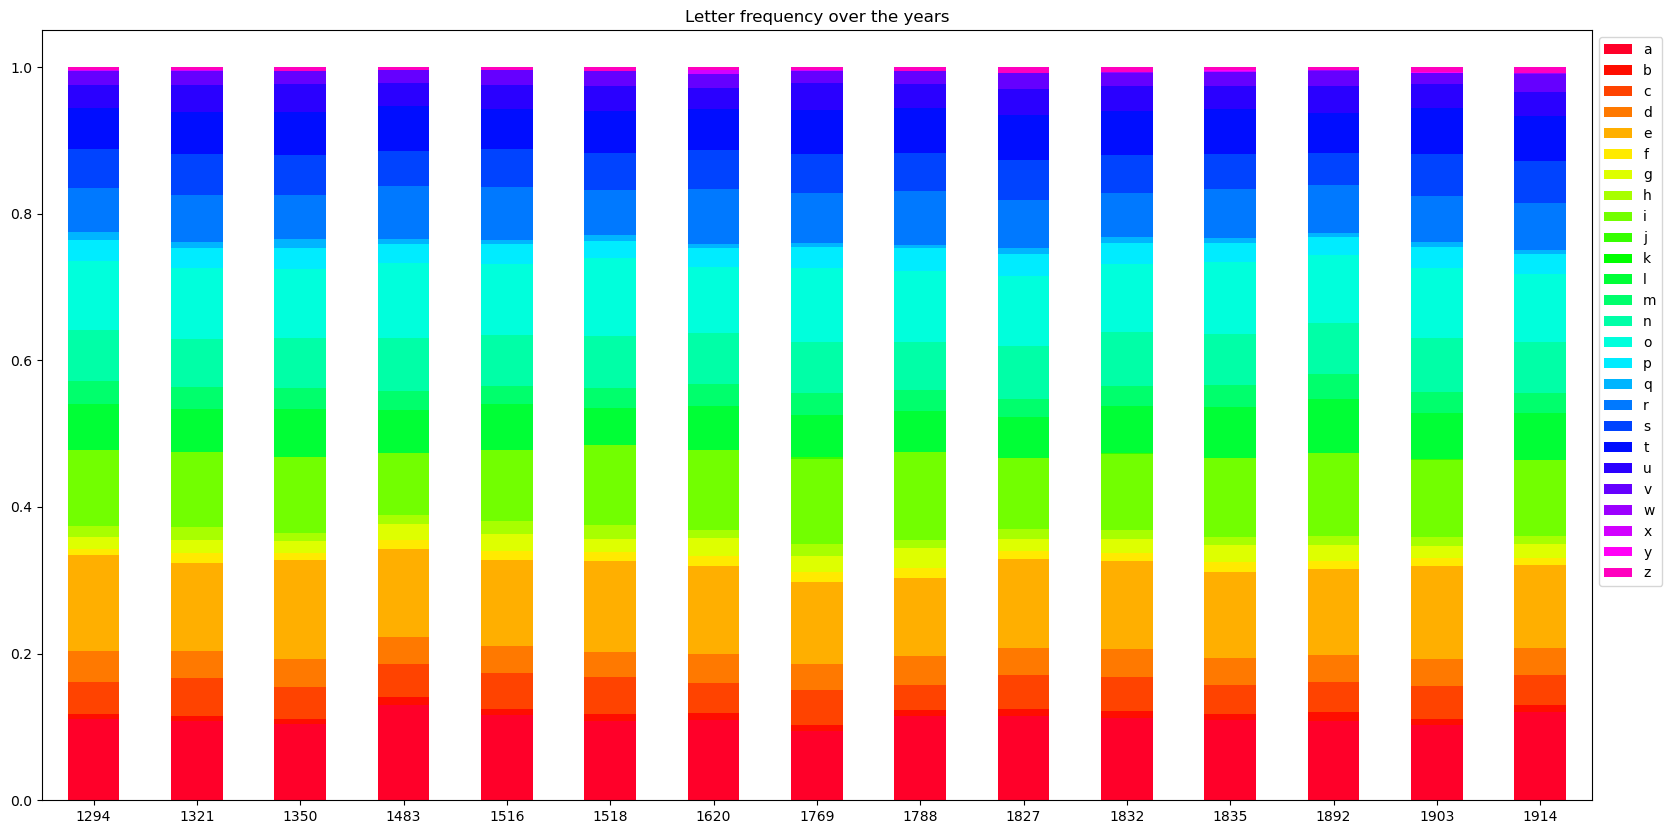

In [28]:
directory = f'../resources/historical_analysis/output_{run_id}'

years = []
for filename in os.listdir(directory):
    year = filename.split('.')[0]
    years.append(year)

df = pd.DataFrame(index=years, columns=[])

for year in years:
    freq_per_year = []
    filepath = f'{directory}/{year}/freq/part-r-00000'
    with open(filepath, 'r') as f:
        for line in f:
            letter, freq = line.strip().split('\t')
            freq = float(freq)
            df.loc[year, letter] = freq

ax = df.plot( kind='bar', stacked=True, title='Letter frequency over the years', figsize=(20, 10), colormap='gist_rainbow', rot=0)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()